## Podstawowe metody przetwarzania obrazu
Ten kod to fragment programu w Pythonie przygotowujący środowisko do przetwarzania i wizualizacji obrazów — szczególnie z użyciem biblioteki scikit-image (skimage), NumPy, i matplotlib.

Co robi ten kod:

* Importuje narzędzia do pracy z obrazami.

* Ustawia domyślne parametry wykresu.

* Definiuje funkcję show_row(), która pozwala łatwo wyświetlać wiele obrazów w jednym wierszu.

* pokazuje przykład użycia tej funkcji.

In [31]:
# ============================================
# Import potrzebnych bibliotek
# ============================================
import numpy as np                          # NumPy – obsługa tablic i obliczeń numerycznych
import matplotlib.pyplot as plt              # Matplotlib – do rysowania i wyświetlania obrazów
from skimage import io, color, exposure, filters, util, morphology
# skimage.io          – wczytywanie/zapisywanie obrazów
# skimage.color       – konwersja przestrzeni barw (np. RGB → grayscale)
# skimage.exposure    – regulacja jasności, kontrastu, histogramów itp.
# skimage.filters     – filtry obrazu (np. rozmycie, wykrywanie krawędzi)
# skimage.util        – operacje pomocnicze (np. dodawanie szumu)
# skimage.morphology  – operacje morfologiczne (np. erozja, dylatacja)
from skimage.metrics import structural_similarity as ssim
# skimage.metrics.ssim – metryka podobieństwa strukturalnego (ocena podobieństwa obrazów)

# ============================================
# Ustawienia wykresów
# ============================================
plt.rcParams["figure.figsize"] = (12, 4)     # Domyślny rozmiar rysunku: szerokość 12 cali, wysokość 4 cale

# ============================================
# Funkcja pomocnicza do wyświetlania obrazów w jednym wierszu
# ============================================
def show_row(images, titles=None, cmap=None):
    """
    Wyświetla kilka obrazów obok siebie w jednym wierszu.

    Parametry:
    -----------
    images : list
        Lista obrazów (tablic NumPy) do wyświetlenia.
    titles : list (opcjonalnie)
        Lista tytułów dla każdego obrazu.
    cmap : str (opcjonalnie)
        Mapa kolorów (np. 'gray' dla obrazów w skali szarości).
    """

    n = len(images)                          # Liczba obrazów
    fig, axes = plt.subplots(1, n)           # Tworzy jeden wiersz z n kolumnami (dla każdego obrazu jedna oś)

    # Iteracja po wszystkich obrazach i ich osiach
    for i, ax in enumerate(np.atleast_1d(axes)):
        ax.imshow(images[i], cmap=cmap[i])      # Wyświetla obraz (z opcjonalną mapą kolorów)
        ax.axis('off')                       # Ukrywa osie (ramki, skale, liczby)
        if titles:                           # Jeśli podano tytuły
            ax.set_title(titles[i])          # Ustawia tytuł nad obrazem

    plt.show()                               # Wyświetla całość

# ============================================
# Przykład użycia (opcjonalnie)
# ============================================
# from skimage import data
# img = data.astronaut()                     # Wczytanie przykładowego obrazu
# gray = color.rgb2gray(img)                 # Konwersja na skalę szarości
# blur = filters.gaussian(gray, sigma=2)     # Rozmycie obrazu filtrem Gaussa
#
# # Wyświetlenie trzech obrazów obok siebie
# show_row([img, gray, blur],
#           titles=["Oryginał", "Skala szarości", "Rozmyty"],
#           cmap='gray')


# Wczytanie + kanały + histogram

Co robi ten kod:
* Wczytuje obraz z pliku (np. lena.png).

* Zapewnia, że ma format RGB (3 kanały).

* Rozdziela obraz na kanały R, G, B.

* Wyświetla oryginał i każdy kanał osobno.

* Konwertuje obraz do skali szarości.

* Rysuje histogram jasności – pokazujący rozkład tonalny obrazu.

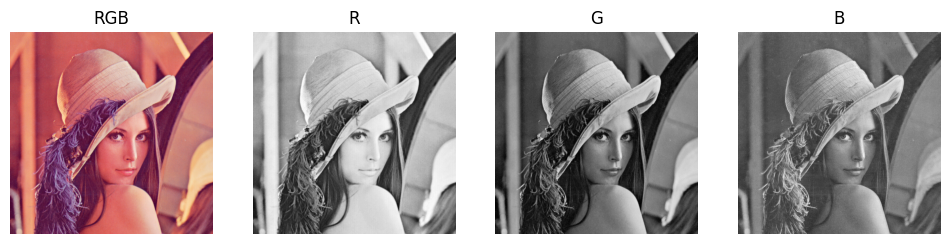

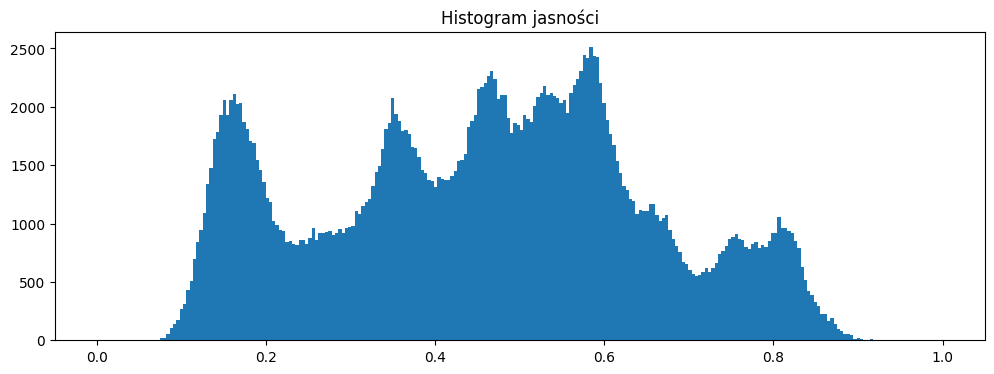

In [35]:
# ============================================
# Wczytanie obrazu i analiza kanałów kolorów
# ============================================

# TODO: Podmień ścieżkę na swój plik lub URL (skimage.io potrafi też czytać obrazy z internetu)
img = io.imread('lena.png')  # Wczytuje obraz z pliku; może być RGB, RGBA lub grayscale (2D)

# ============================================
# Ujednolicenie formatu obrazu do RGB
# ============================================
# Jeśli obraz jest w skali szarości (2D) → powiel kanał 3 razy, aby uzyskać pseudo-RGB.
# Jeśli obraz ma kanał alfa (RGBA) → usuń go, zostawiając tylko pierwsze 3 kanały (R, G, B).
if img.ndim == 2:
    img_rgb = np.stack([img, img, img], axis=-1)  # Tworzy RGB z jednego kanału
else:
    img_rgb = img[..., :3]  # Usuwa kanał alfa (jeśli istnieje), zachowując R, G, B

# ============================================
# a) Podgląd RGB i kanałów R / G / B
# ============================================
# Wyodrębnienie poszczególnych kanałów koloru z obrazu RGB.
r = img_rgb[..., 0]  # Kanał czerwony (Red)
g = img_rgb[..., 1]  # Kanał zielony (Green)
b = img_rgb[..., 2]  # Kanał niebieski (Blue)

# Wyświetlenie oryginalnego obrazu RGB oraz trzech kanałów R, G, B obok siebie.
# Kanały są pokazane w skali szarości, aby uwidocznić ich intensywność.
show_row([img_rgb, r, g, b],
          ['RGB', 'R', 'G', 'B'],
          cmap=['brg', 'gray', 'gray', 'gray'])

# ============================================
# b) Histogram jasności obrazu
# ============================================
# Konwersja z RGB do skali szarości – wykorzystuje wagowe przeliczenie ludzkiej percepcji jasności:
# Y = 0.2125 * R + 0.7154 * G + 0.0721 * B
# Wynik to obraz typu float z wartościami od 0 (czarny) do 1 (biały).
gray = color.rgb2gray(img_rgb)

# Rysowanie histogramu rozkładu jasności pikseli.
# gray.ravel() spłaszcza obraz 2D do jednowymiarowej tablicy wszystkich wartości pikseli.
plt.figure()
plt.hist(gray.ravel(), bins=256, range=(0, 1))  # 256 przedziałów dla jasności od 0 do 1
plt.title('Histogram jasności')  # Tytuł wykresu
plt.show()  # Wyświetlenie histogramu


Normalizacja, Wyrównanie histogramu





# Normalizacja histogramu (ang. histogram normalization lub contrast stretching)
Normalizacja rozciąga zakres jasności obrazu tak, by wykorzystać cały możliwy przedział — np. od 0 do 1 (dla float) lub od 0 do 255 (dla uint8).

Przykład:

Jeśli obraz ma piksele tylko w zakresie [50, 180], to normalizacja przeskaluje je do [0, 255].
Dzięki temu:
* cienie staną się czarne,
* jasne miejsca – jaśniejsze,
* kontrast wzrośnie liniowo.

# Wyrównanie histogramu (ang. histogram equalization)
Wyrównanie histogramu zmienia rozkład jasności pikseli, aby histogram był bardziej płaski i równomierny.
Nie tylko rozciąga, ale też nieliniowo przekształca wartości, tak by różne poziomy jasności były reprezentowane z podobną częstością.

Efekt:
* zwiększa kontrast lokalny,
* uwidacznia szczegóły w ciemnych i jasnych partiach obrazu,
* histogram po operacji staje się „bardziej równy”.

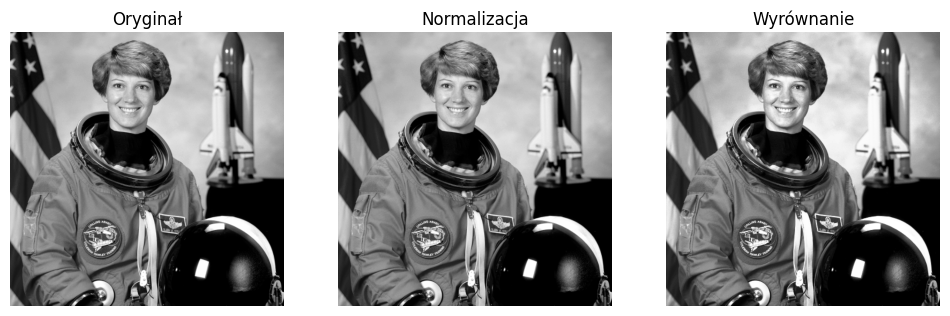

In [4]:
# Import potrzebnych bibliotek
from skimage import data, color, exposure
import matplotlib.pyplot as plt

# Wczytanie obrazu astronauty z wbudowanego zestawu skimage i konwersja do skali szarości
# Funkcja rgb2gray() zamienia obraz RGB na odcienie szarości, co ułatwia analizę jasności.
img = color.rgb2gray(data.astronaut())

# Normalizacja kontrastu
# Funkcja rescale_intensity() rozciąga zakres jasności pikseli tak, by najmniejsza wartość = 0, a największa = 1.
# Dzięki temu obraz lepiej wykorzystuje dostępny zakres intensywności i ma wyraźniejszy kontrast.
norm = exposure.rescale_intensity(img, in_range='image', out_range=(0, 1))

# Wyrównanie histogramu (Histogram Equalization)
# equalize_hist() modyfikuje rozkład intensywności tak, aby histogram był bardziej równomierny.
# To poprawia kontrast, szczególnie w ciemnych i jasnych fragmentach obrazu.
eq = exposure.equalize_hist(img)

# Wizualizacja wyników obok siebie
# Tworzymy 3 wykresy: oryginał, wersję po normalizacji i po wyrównaniu histogramu.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ['Oryginał', 'Normalizacja', 'Wyrównanie']

# Wyświetlenie każdego obrazu w skali szarości z odpowiednim tytułem
for ax, im, t in zip(axes, [img, norm, eq], titles):
    ax.imshow(im, cmap='gray')  # Wyświetlenie obrazu w odcieniach szarości
    ax.set_title(t)             # Ustawienie tytułu wykresu
    ax.axis('off')              # Ukrycie osi dla czystszego wyglądu

# Wyświetlenie całej figury
plt.show()

# Podstawowe przekształcenia geometryczne obrazu
Przekształcenia geometryczne należą do podstawowych operacji w przetwarzaniu obrazów cyfrowych. Ich celem jest zmiana położenia, orientacji lub rozmiaru elementów obrazu bez modyfikacji jego treści (czyli wartości jasności i kolorów). W przeciwieństwie do metod poprawy kontrastu czy filtracji, przekształcenia geometryczne nie zmieniają informacji o pikselach, lecz zmieniają ich rozmieszczenie w przestrzeni obrazu.

Do najczęściej stosowanych przekształceń geometrycznych należą:

* Translacja (przesunięcie) – zmiana położenia obrazu w płaszczyźnie (np.
przesunięcie w prawo lub w dół).
* Rotacja (obrót) – obrót obrazu wokół zadanego punktu, najczęściej środka.
* Skalowanie (reskalowanie) – powiększenie lub pomniejszenie obrazu poprzez zmianę odległości między pikselami.
* Odbicie (symetria lustrzana) – zamiana stron obrazu w poziomie lub pionie.
* Transformacje afiniczne (affine transformations) – ogólniejsze przekształcenia, które obejmują rotację, skalowanie, translację i ścinanie (shear).
* Transformacje perspektywiczne (projective transformations) – bardziej złożone operacje pozwalające odwzorować efekty wynikające ze zmiany punktu widzenia kamery.

Poniżej w kodzie zastosowano przykład przekaszłcenia obrazu:
* Obrót (rotate) – zmienia orientację obrazu o określony kąt.
* Odbicie lustrzane (flip) – odwraca obraz w poziomie.
* Skalowanie (rescale) – zmniejsza lub powiększa obraz.

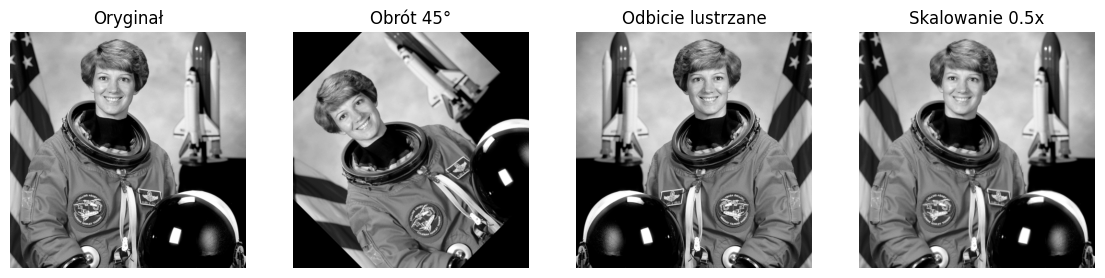

In [5]:
# Import potrzebnych bibliotek
from skimage import data, color, transform
import matplotlib.pyplot as plt

# Wczytanie przykładowego obrazu i konwersja do skali szarości
# Używamy zdjęcia astronauty, które jest dostępne w skimage.
img = color.rgb2gray(data.astronaut())

# Obrót obrazu o 45 stopni
# transform.rotate() obraca obraz o zadany kąt (w stopniach, przeciwnie do ruchu wskazówek zegara).
rotated = transform.rotate(img, angle=45)

# Odbicie lustrzane w poziomie
# slicing [:, ::-1] odwraca kolejność kolumn (pionowych pikseli), co daje efekt lustrzanego odbicia.
flipped = img[:, ::-1]

# Skalowanie (zmiana rozmiaru)
# transform.rescale() zmienia wielkość obrazu o podany współczynnik (tu 0.5 = zmniejszenie do 50%).
scaled = transform.rescale(img, scale=0.5, anti_aliasing=True)

# Wizualizacja wszystkich przekształceń
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
titles = ['Oryginał', 'Obrót 45°', 'Odbicie lustrzane', 'Skalowanie 0.5x']

# Wyświetlenie każdego obrazu w odcieniach szarości
for ax, im, t in zip(axes, [img, rotated, flipped, scaled], titles):
    ax.imshow(im, cmap='gray')
    ax.set_title(t)
    ax.axis('off')

# Wyświetlenie wyniku
plt.show()

# Konwersja przestrzeni barw

Przestrzeń barw (ang. color space) to sposób matematycznego opisu koloru, który określa, jak kolory są reprezentowane i interpretowane przez komputer.

Różne przestrzenie barw lepiej nadają się do różnych zastosowań w przetwarzaniu obrazów i wizji komputerowej.
Konwersja umożliwia:

* Oddzielenie jasności od koloru
W przestrzeniach takich jak HSV, LAB czy YUV, można analizować jasność (np. „Value”, „L” lub „Y”) osobno od barwy.
To bardzo przydatne przy analizie obrazów, gdy oświetlenie jest nierównomierne.
* Segmentację kolorów
W przestrzeni HSV łatwo odseparować obiekty o określonej barwie, bo „Hue” opisuje odcień w sposób intuicyjny (np. czerwony ≈ 0°, niebieski ≈ 240°).
* Lepsze odwzorowanie percepcji człowieka
W przestrzeni LAB różnice między kolorami są bardziej zgodne z tym, jak widzi je człowiek — przydatne przy porównywaniu obrazów czy ocenie jakości.
* Kompresję i przetwarzanie wideo
Przestrzeń YUV (lub YCbCr) pozwala oddzielić luminancję (jasność) od chrominancji (koloru).
Dzięki temu można kompresować dane o barwie bez dużej utraty jakości obrazu — tak działa np. JPEG i MPEG.

Dodatkowe funkcje w skimage.color:

* color.rgb2gray() – RGB → skala szarości
* color.gray2rgb() – grayscale → RGB
* color.hsv2rgb() – HSV → RGB
* color.lab2rgb() – LAB → RGB
* color.yuv2rgb() – YUV → RGB


Analiza kodu poniżej:
* Wczytujemy obraz RGB (np. astronauta ze skimage.data).
* Konwertujemy go kolejno do innych przestrzeni barw:
* rgb2hsv() – użyteczne np. przy segmentacji kolorów.
* rgb2lab() – przestrzeń dopasowana do ludzkiej percepcji kolorów.
* rgb2yuv() – często stosowana w kompresji wideo i obrazów.

Wizualizujemy oryginał i poszczególne kanały każdej przestrzeni:

* w HSV: H (odcień), S (nasycenie), V (jasność),
* w LAB: L (luminancja), a i b (składowe kolorów),
* w YUV: Y (jasność), U i V (informacja o barwie).




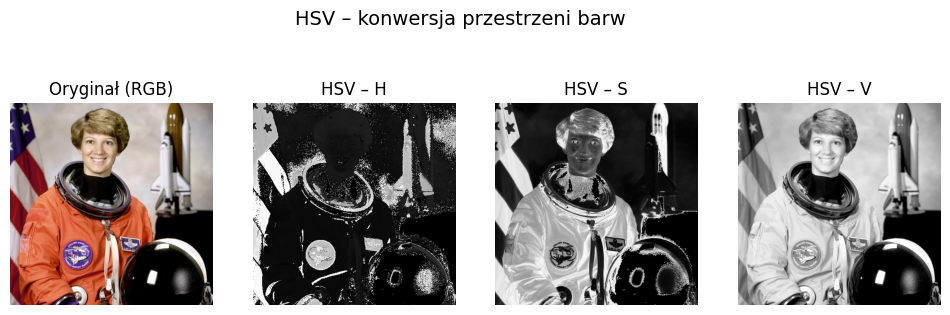

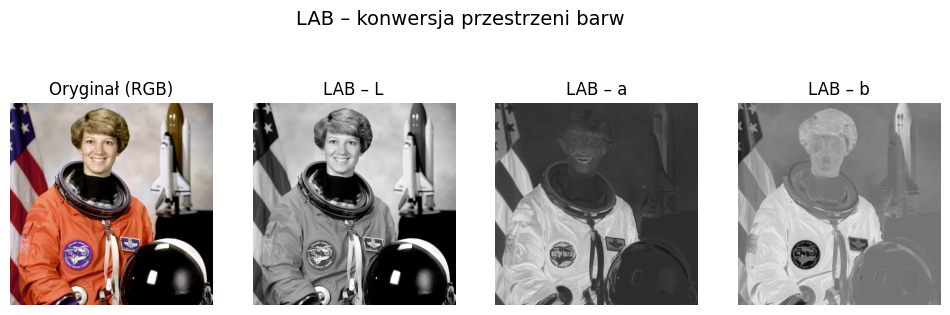

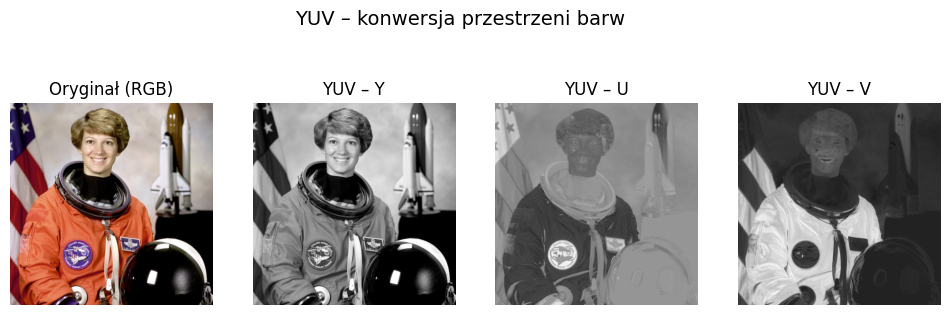

In [6]:
# ============================================
# Przykład: Zmiana przestrzeni barw w Pythonie (scikit-image)
# ============================================

import matplotlib.pyplot as plt
from skimage import data, color

# Wczytanie przykładowego obrazu z biblioteki skimage
img_rgb = data.astronaut()   # Obraz w formacie RGB (Red, Green, Blue)

# ============================================
# RGB → HSV
# ============================================
# HSV (Hue, Saturation, Value)
# Hue – barwa (0–1)
# Saturation – nasycenie koloru (0–1)
# Value – jasność (0–1)
img_hsv = color.rgb2hsv(img_rgb)

# ============================================
# RGB → LAB
# ============================================
# LAB to przestrzeń, w której:
# L – jasność (Lightness)
# a – składowa koloru od zielonego do czerwonego
# b – składowa koloru od niebieskiego do żółtego
img_lab = color.rgb2lab(img_rgb)

# ============================================
# RGB → YUV
# ============================================
# YUV (lub YCbCr) rozdziela luminancję (Y) od chrominancji (U,V).
# Często używana w telewizji i kompresji wideo (np. w JPEG).
img_yuv = color.rgb2yuv(img_rgb)

# ============================================
# Wizualizacja wyników
# ============================================
# Tworzymy 3 wiersze (dla przestrzeni HSV, LAB, YUV)
# i w każdym pokazujemy oryginał oraz 3 kanały składowe
def show_color_space_conversion(original, converted, space_name, channel_names):
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(f'{space_name} – konwersja przestrzeni barw', fontsize=14)
    axes[0].imshow(original)
    axes[0].set_title("Oryginał (RGB)")
    axes[0].axis("off")

    for i, name in enumerate(channel_names):
        axes[i + 1].imshow(converted[..., i], cmap='gray')
        axes[i + 1].set_title(f'{space_name} – {name}')
        axes[i + 1].axis('off')
    plt.show()

# Wyświetlenie dla różnych przestrzeni
show_color_space_conversion(img_rgb, img_hsv, "HSV", ["H", "S", "V"])
show_color_space_conversion(img_rgb, img_lab, "LAB", ["L", "a", "b"])
show_color_space_conversion(img_rgb, img_yuv, "YUV", ["Y", "U", "V"])

# Zadanie 1

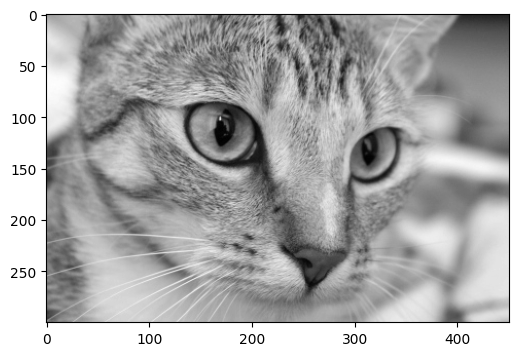

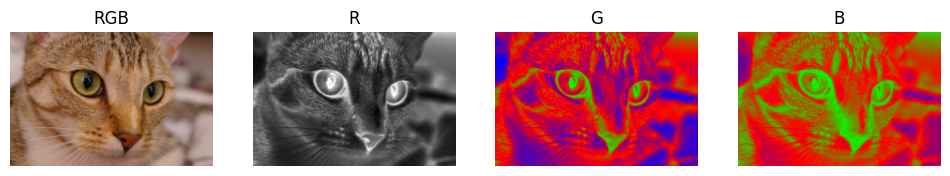

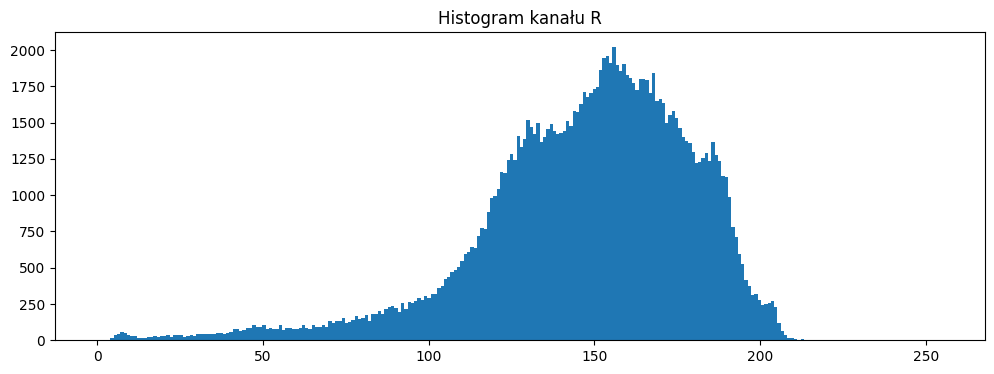

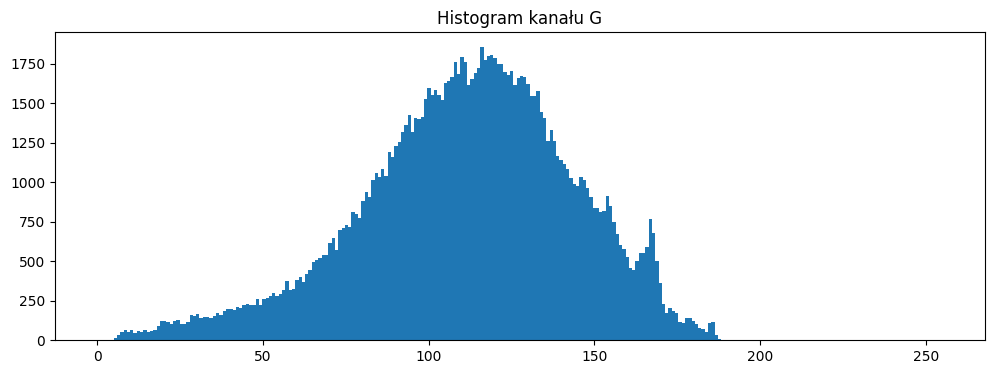

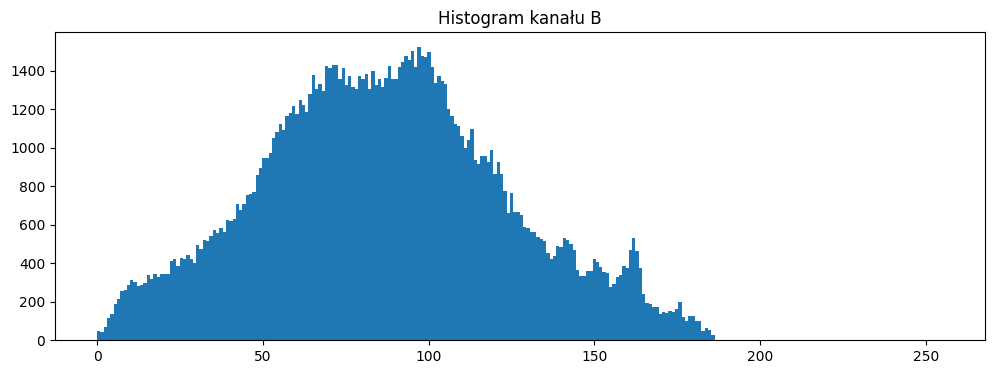

In [39]:
import matplotlib.pyplot as plt
from skimage import data, color

img_rgb = data.cat()

img_gray = color.rgb2gray(img_rgb)

r = img_rgb[..., 0]
g = img_rgb[..., 1]
b = img_rgb[..., 2]

#plt.imshow(img_rgb)

plt.imshow(img_gray, cmap='grey')

show_row([img_rgb, r, g, b],
          ['RGB', 'R', 'G', 'B'], ['brg', 'R', 'brg_r', 'brg_r'])

def plot_channel_hist(channel, channel_name = None):
    plt.figure()
    plt.hist(channel.ravel(), bins=256, range=(0, 255))
    plt.title('Histogram kanału ' + channel_name)
    plt.show()

plot_channel_hist(r, "R");
plot_channel_hist(g, "G");
plot_channel_hist(b, "B");